# Hot Plasma Paper I--Figures

Here, we'll create all figures needed for "Hot" Plasma Paper I

+ Figure 1: $T$ and $n$ for single-fluid case for multiple heating durations, two panels.
+ Figure 2: $T_e,T_i$ and $n$ for two-fluid case for $\tau=200,40$ s, two panels.
+ Figure 3: $\mathrm{EM}(T)$ distributions for $\tau=20,40,200,500$ s, keeping $q=10$ erg cm$^{-3}$ s$^{-1}$ constant
+ Figure 4: $\mathrm{EM}(T)$ distributions for $H^{'}_0=H_0/2,H_0,2H_0,5H_0$ for $H_0$ such that $q=10$ erg cm$^{-3}$ s$^{-1}$ for $\tau=200$ s, one panel
    + Maybe have multiple panels for multiple heating cases?
    + Panel 2?: $n_0=2\times10^8,2\times10^9$ cm$^{-3}$, with $H_0$ and $\tau=200$ s
    + Panel 3?: $L=20,40,75$ Mm, with $H_0$ and $\tau=200$ s
    + Panel 4?: $\mathrm{EM}(T)$ for Spitzer conduction, flux limiting with $f=1/6$ and $f=1/30$, (for both $T$ and $T_{eff}$?)
+ Figure 5: $\mathrm{EM}(T)$ for electron, ion heating for long,short pulses
+ Figure 6: $T,T_{eff}$ for long and short heating durations for electron and ion heating; show $T, T_e, T_{eff}$ for each.
+ Figure 7: $\mathrm{EM}$(T) including $T_{eff}$; not sure about how to incorporate varying parameters.

Not sure if heat flux comparisons are necessary for electron and ion heating as well.

In [1]:
#Import needed modules
import os
import sys
from imp import reload
import numpy as np
import astropy.constants as ac
from scipy.optimize import curve_fit
import seaborn.apionly as sns
from matplotlib import ticker
import matplotlib.pyplot as plt
plt.style.use('papers')
%matplotlib inline
sys.path.append(os.path.join(os.environ['RESEARCH_DIR'],'EBTEL_C/bin/'))
sys.path.append(os.path.join(os.environ['RESEARCH_DIR'],'EBTEL_analysis/src/'))
sys.path.append(os.path.join(os.environ['RESEARCH_DIR'],'boilerplate'))
import ebtel_wrapper as ew
import ebtel_run as ebr
import plot_helpers as ph
import em_binner as emb
reload(ebr)
reload(ew)
reload(emb)

/opt/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/opt/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'em_binner' from '/home/wtb2/Documents/EBTEL_analysis/src/em_binner.py'>

First, we want to find the background heating value which will give us the appropriate initial density such that our results are consistent with those of HYDRAD.

In [2]:
tsch = 2.*ac.k_B.cgs.value*1.4e+6/(ac.m_p.cgs.value*2.74e+4)
n0 = 2e+8/0.6*np.exp(8.e+9/np.pi/tsch*(1.-np.sin(np.pi/5.)))
print('%e'%n0)

3.775058e+08


In [3]:
loopLength = 4e+9
r3 = 2.0
chi = 1.95e-18
r2 = 0.6
alpha=-2.0/3.0
kappa0 = 1e-6
q0 = (n0**2*(1.+r3)*chi*r2**alpha*(7.*loopLength**2*r3/2./kappa0/(1.+r3))**(2.*alpha/7))**(1.0/(1.0 - 2.0*alpha/7))
print(q0)

9.25427774199e-05


## Run Preparation

Set up a base dictionary. We'll modify it appropriately.

In [4]:
#input dictionary
config_dict = {'usage_option':'dem','rad_option':'rk','dem_option':'new','heat_flux_option':'classical',
              'solver':'rka4','ic_mode':'st_eq','print_plasma_params':'True'}
config_dict['total_time'] = 5000
config_dict['tau'] = 0.5
config_dict['rka_error'] = 1.0e-6
config_dict['index_dem'] = 451
config_dict['sat_limit'] = 1.0/6.0
config_dict['h_back'] = 3.5e-5
config_dict['heating_shape'] = 'triangle'
config_dict['t_start_switch'] = 'uniform'
config_dict['t_end_switch'] = 'uniform'
config_dict['T0'] = 1.0e+6
config_dict['n0'] = 1.0e+8
config_dict['t_start'] = 0.0
config_dict['mean_t_start'] = 1000
config_dict['std_t_start'] = 1000
config_dict['amp_switch'] = 'uniform'
config_dict['amp0'] = 0.001
config_dict['amp1'] = 0.01
config_dict['alpha'] = 1.5
config_dict['loop_length'] = 40.0
config_dict['num_events'] = 1
config_dict['t_pulse_half'] = 100
config_dict['h_nano'] = 0.1
config_dict['sample_rate'] = 1
base_output = os.path.join(os.environ['RESEARCH_DIR'],'research_notebook/EBTEL/ebtel_data/hp1_figs_sandbox')

Write a function to run EBTEL model and easily vary and save the relevant parameters.

In [5]:
def t0_scaling(L,n):
    return (1.83e+3)**(3./2.)*np.sqrt(2.*1.38e-16*L*n)

In [6]:
def run_and_print(input_dict,tau,h0,L,f,flux_opt,run_inst,T0=False,n0=False):
    #set params
    input_dict['t_pulse_half'] = tau/2.0
    input_dict['h_nano'] = h0
    input_dict['loop_length'] = L
    input_dict['sat_limit'] = f
    input_dict['heat_flux_option'] = flux_opt
    input_dict['heat_species'] = 'electron'
    if T0 and n0:
        input_dict['ic_mode'] = 'force'
        input_dict['T0'] = T0
        input_dict['n0'] = n0
    else:
        input_dict['ic_mode'] = config_dict['ic_mode']
    #print config file
    input_dict['output_file'] = base_output + '_single'
    ew.print_xml_config(input_dict,config_file=input_dict['output_file']+'.xml')
    #single-fluid    
    #run model
    ew.run_ebtel('/home/wtb2/Documents/EBTEL_C/bin/','',config_file=input_dict['output_file']+'.xml',verbose=False)
    #save parameters to list
    temp = np.loadtxt(input_dict['output_file']+'.txt')
    t,T,n = temp[:,0],temp[:,1],temp[:,2]
    np.savetxt(os.path.join(os.path.dirname(config_dict['output_file']+'.txt'),'.ips.txt'),
           np.transpose([t,T,n]),header=str(len(temp[:,0])),comments='',fmt='%f\t%e\t%e')
    #two-fluid
    #--electron heating
    input_dict['output_file'] = base_output + '_electron'
    ew.print_xml_config(input_dict,config_file=input_dict['output_file']+'.xml')
    #run model
    run_inst.run_ebtel_single(input_dict['output_file']+'.xml',verbose=False)
    #save parameters to list
    temp = np.loadtxt(input_dict['output_file']+'.txt')
    te,Tee,Tei,ne = temp[:,0],temp[:,1],temp[:,2],temp[:,3]
    np.savetxt(os.path.join(os.path.dirname(config_dict['output_file']+'.txt'),'.ips.txt'),
           np.transpose([te,Tee,ne]),header=str(len(temp[:,0])),comments='',fmt='%f\t%e\t%e')
    #--ion heating
    #print config file
    input_dict['heat_species'] = 'ion'
    input_dict['output_file'] = base_output + '_ion'
    ew.print_xml_config(input_dict,config_file=input_dict['output_file']+'.xml')
    #run model
    run_inst.run_ebtel_single(input_dict['output_file']+'.xml',verbose=False)
    #save parameters to list
    temp = np.loadtxt(input_dict['output_file']+'.txt')
    ti,Tie,Tii,ni = temp[:,0],temp[:,1],temp[:,2],temp[:,3]
    np.savetxt(os.path.join(os.path.dirname(config_dict['output_file']+'.txt'),'.ips.txt'),
           np.transpose([ti,Tie,ni]),header=str(len(temp[:,0])),comments='',fmt='%f\t%e\t%e')
    return {'t':t,'te':te,'ti':ti,'T':T,'Tee':Tee,'Tei':Tei,'Tie':Tie,'Tii':Tii,'n':n,'ne':ne,'ni':ni}

Instantiate runner class to run the EBTEL model.

In [7]:
runner = ebr.Runner('/home/wtb2/Documents/EBTEL-2fluid_repo/bin/','')

In [8]:
def spatial_average(s,f,mp,eps_mp):
    #calculate bounds
    mp_lower = mp - eps_mp/2.0*mp
    mp_upper = mp + eps_mp/2.0*mp
    #find f and s within specified bounds
    i_eb = np.where((s>=mp_lower) & (s<=mp_upper))[0]
    s_eb = s[i_eb]
    f_eb = f[i_eb]
    #take average
    delta_s = np.gradient(s_eb)
    return 1.0/(np.sum(delta_s))*np.sum(f_eb*delta_s)

## Data Gathering

Here, do all the runs necessary/collect all data needed in Python structures, including EBTEL runs, HYDRAD files, and NEI runs.

### EBTEL

In [9]:
#vary pulse duration
tau_h = [20,40,200,500]
tau_h_results = []
for t in tau_h:
    results = run_and_print(config_dict,t,20.0/t,40.0,1,'classical',runner)
    tau_h_results.append(results)

#vary H0 (deprecated)
#h0 = [.05,.1,.2,.5]
#for i in range(len(h0)):
#    results = run_and_print(config_dict,200.0,h0[i],40.0,1,'classical',runner)
    
#vary L (deprecated)
#loop_length = [20.0,40.0,75.0]
#for i in range(len(loop_length)):
#    results = run_and_print(config_dict,200.0,0.1,loop_length[i],1,'classical',runner)
    
#vary heat flux behavior
flux_lim = [[1.0/6.0,'limited'],[1.0/30.0,'limited'],[1.0,'classical']]
flux_lim_results = []
for i in range(len(flux_lim)):
    results = run_and_print(config_dict,200.0,0.1,40.0,flux_lim[i][0],flux_lim[i][1],runner)
    flux_lim_results.append(results)

### HYDRAD

In [10]:
hfRes_format = '/home/ricesolarphyiscs/Documents/HYDRAD_v4_%s/Results/profile%d.phy'
hydrad_time = np.arange(0,5001)
hydrad_labs = ['tau20s','tau40s','tau200s','tau500s']
hydrad_res = {}
loop_midpoint = 4.5e+9
int_perc = 0.8

In [11]:
#tau=20 s run
Te_avg = []
Ti_avg = []
n_avg = []
for t in hydrad_time:
    #Load results
    temp = np.loadtxt(hfRes_format%('20s_faster',t))
    #slice
    s_temp = temp[:,0]
    Te_temp = temp[:,7]
    Ti_temp = temp[:,8]
    n_temp = temp[:,3]
    #save averages
    Te_avg.append(spatial_average(s_temp,Te_temp,loop_midpoint,int_perc))
    Ti_avg.append(spatial_average(s_temp,Ti_temp,loop_midpoint,int_perc))
    n_avg.append(spatial_average(s_temp,n_temp,loop_midpoint,int_perc))
    
hydrad_res['tau20s'] = {'Te':Te_avg,'Ti':Ti_avg,'n':n_avg}

In [12]:
#tau=40 s run
Te_avg = []
Ti_avg = []
n_avg = []
for t in hydrad_time:
    #Load results
    temp = np.loadtxt(hfRes_format%('40s_faster',t))
    #slice
    s_temp = temp[:,0]
    Te_temp = temp[:,7]
    Ti_temp = temp[:,8]
    n_temp = temp[:,3]
    #save averages
    Te_avg.append(spatial_average(s_temp,Te_temp,loop_midpoint,int_perc))
    Ti_avg.append(spatial_average(s_temp,Ti_temp,loop_midpoint,int_perc))
    n_avg.append(spatial_average(s_temp,n_temp,loop_midpoint,int_perc))
    
hydrad_res['tau40s'] = {'Te':Te_avg,'Ti':Ti_avg,'n':n_avg}

In [13]:
#tau=200 s run
Te_avg = []
Ti_avg = []
n_avg = []
for t in hydrad_time:
    #Load results
    temp = np.loadtxt(hfRes_format%('200s',t))
    #slice
    s_temp = temp[:,0]
    Te_temp = temp[:,7]
    Ti_temp = temp[:,8]
    n_temp = temp[:,3]
    #save averages
    Te_avg.append(spatial_average(s_temp,Te_temp,loop_midpoint,int_perc))
    Ti_avg.append(spatial_average(s_temp,Ti_temp,loop_midpoint,int_perc))
    n_avg.append(spatial_average(s_temp,n_temp,loop_midpoint,int_perc))
    
hydrad_res['tau200s'] = {'Te':Te_avg,'Ti':Ti_avg,'n':n_avg}

In [14]:
#tau=500 s run
Te_avg = []
Ti_avg = []
n_avg = []
for t in hydrad_time:
    #Load results
    temp = np.loadtxt(hfRes_format%('500s',t))
    #slice
    s_temp = temp[:,0]
    Te_temp = temp[:,7]
    Ti_temp = temp[:,8]
    n_temp = temp[:,3]
    #save averages
    Te_avg.append(spatial_average(s_temp,Te_temp,loop_midpoint,int_perc))
    Ti_avg.append(spatial_average(s_temp,Ti_temp,loop_midpoint,int_perc))
    n_avg.append(spatial_average(s_temp,n_temp,loop_midpoint,int_perc))
    
hydrad_res['tau500s'] = {'Te':Te_avg,'Ti':Ti_avg,'n':n_avg}

### NEI `Ion_Pop_Solver` Runs

Format the data to be read by the `Ion_Pop_Solver` code

In [15]:
#short pulse
#single
np.savetxt(os.path.join(os.path.dirname(base_output+'.txt'),'fig6a.single.ips.txt'),
           np.transpose([tau_h_results[0]['t'],tau_h_results[0]['T'],tau_h_results[0]['n']]),
           header=str(len(tau_h_results[0]['t'])),comments='',fmt='%f\t%e\t%e')
#electron
np.savetxt(os.path.join(os.path.dirname(base_output+'.txt'),'fig6a.electron.ips.txt'),
           np.transpose([tau_h_results[0]['te'],tau_h_results[0]['Tee'],tau_h_results[0]['ne']]),
           header=str(len(tau_h_results[0]['te'])),comments='',fmt='%f\t%e\t%e')
#ion
np.savetxt(os.path.join(os.path.dirname(base_output+'.txt'),'fig6a.ion.ips.txt'),
           np.transpose([tau_h_results[0]['ti'],tau_h_results[0]['Tie'],tau_h_results[0]['ni']]),
           header=str(len(tau_h_results[0]['ti'])),comments='',fmt='%f\t%e\t%e')
#long pulse
#single
np.savetxt(os.path.join(os.path.dirname(base_output+'.txt'),'fig6b.single.ips.txt'),
           np.transpose([tau_h_results[-1]['t'],tau_h_results[-1]['T'],tau_h_results[-1]['n']]),
           header=str(len(tau_h_results[-1]['t'])),comments='',fmt='%f\t%e\t%e')
#electron
np.savetxt(os.path.join(os.path.dirname(base_output+'.txt'),'fig6b.electron.ips.txt'),
           np.transpose([tau_h_results[-1]['te'],tau_h_results[-1]['Tee'],tau_h_results[-1]['ne']]),
           header=str(len(tau_h_results[-1]['te'])),comments='',fmt='%f\t%e\t%e')
#ion
np.savetxt(os.path.join(os.path.dirname(base_output+'.txt'),'fig6b.ion.ips.txt'),
           np.transpose([tau_h_results[-1]['ti'],tau_h_results[-1]['Tie'],tau_h_results[-1]['ni']]),
           header=str(len(tau_h_results[-1]['ti'])),comments='',fmt='%f\t%e\t%e')

Now run the code (if necessary) and then load the results into memory.

In [16]:
#load variables
f6a_single = np.loadtxt('/home/wtb2/Documents/research_notebook/EBTEL/ebtel_data/fig6a.single.sol.ips.txt')
f6a_electron = np.loadtxt('/home/wtb2/Documents/research_notebook/EBTEL/ebtel_data/fig6a.electron.sol.ips.txt')
f6a_ion = np.loadtxt('/home/wtb2/Documents/research_notebook/EBTEL/ebtel_data/fig6a.ion.sol.ips.txt')
f6b_single = np.loadtxt('/home/wtb2/Documents/research_notebook/EBTEL/ebtel_data/fig6b.single.sol.ips.txt')
f6b_electron = np.loadtxt('/home/wtb2/Documents/research_notebook/EBTEL/ebtel_data/fig6b.electron.sol.ips.txt')
f6b_ion = np.loadtxt('/home/wtb2/Documents/research_notebook/EBTEL/ebtel_data/fig6b.ion.sol.ips.txt')

## Figure 1

Three panels: first panel $8\times5$ showing $T(t)$ for EBTEL and HYDRAD, second panel $8\times5$ showing $n(t)$ for EBTEL and HYDRAD, third panel $8\times10$ showing $EM(T)$ for EBTEL and HYDRAD. Here, we will look at several different values for the pulse duration $\tau_H=20,40,200,500$ s.

### Panel 1

Temperature as a function of time for all $\tau$ for both HYDRAD and EBTEL.

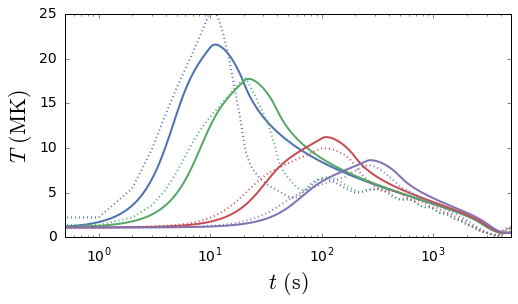

In [35]:
fig = plt.figure(figsize=(8,4))
ax = fig.gca()
#plotting
for i in range(len(tau_h_results)):
    ax.plot(tau_h_results[i]['t'],tau_h_results[i]['T']/1e+6,color=sns.color_palette('deep')[i],
               linestyle='solid',label=r'$\tau=%d$ $\mathrm{s}$'%tau_h[i])
    ax.plot(hydrad_time,np.array(hydrad_res[hydrad_labs[i]]['Te'])/1e+6,color=sns.color_palette('deep')[i],
               linestyle='dotted')
#scale
ax.set_xscale('log')
#limits
ax.set_xlim([0,5000])
ax.set_ylim([0,25])
#tick labels
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
#axes labels
ax.set_xlabel(r'$t$ $\mathrm{(s)}$')
ax.set_ylabel(r'$T$ $\mathrm{(MK)}$')
#legend
#ax.legend()
plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_1/figures/f1a.eps',format='eps',dpi=1000)
plt.show()

### Panel 2
Density as a function of time for all $\tau$ for both HYDRAD and EBTEL.

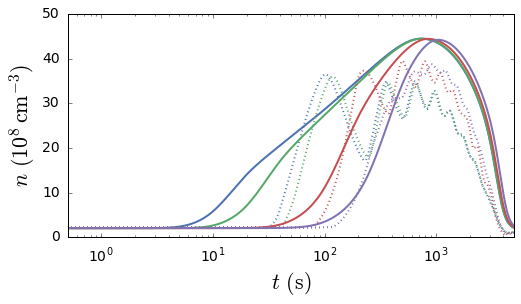

In [36]:
fig = plt.figure(figsize=(8,4))
ax = fig.gca()
#plotting
for i in range(len(tau_h_results)):
    ax.plot(tau_h_results[i]['t'],tau_h_results[i]['n']/1e+8,color=sns.color_palette('deep')[i],
               linestyle='solid',label=r'$\tau=%d$ $\mathrm{s}$'%tau_h[i])
    ax.plot(hydrad_time,np.array(hydrad_res[hydrad_labs[i]]['n'])/1e+8,color=sns.color_palette('deep')[i],
               linestyle='dotted')
#scale
ax.set_xscale('log')
#limits
ax.set_xlim([0,5000])
ax.set_ylim([0,50])
#tick labels
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
#axes labels
ax.set_xlabel(r'$t$ $\mathrm{(s)}$')
ax.set_ylabel(r'$n$ $(10^8\,\mathrm{cm}^{-3})$')
#legend
#ax.legend()
plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_1/figures/f1b.eps',format='eps',dpi=1000)
plt.show()

### Panel 3

$\mathrm{EM}(T)$  for all pulse durations for EBTEL and HYDRAD

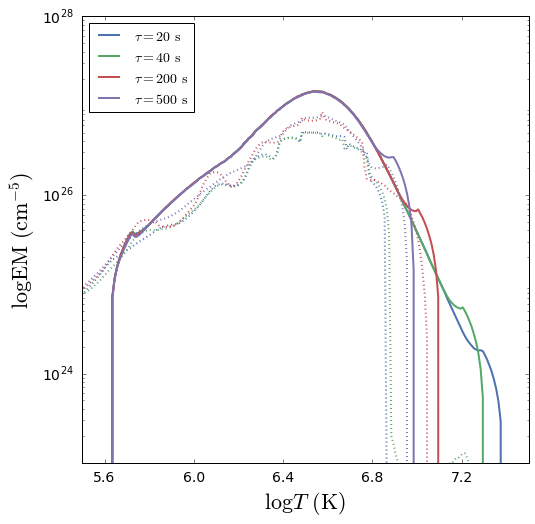

In [37]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
#plotting
for i in range(len(tau_h_results)):
    #EBTEL
    binner = emb.EM_Binner(tau_h_results[i]['t'],tau_h_results[i]['T'],tau_h_results[i]['n'],
                           2*config_dict['loop_length']*1e+8)
    binner.build_em_dist()
    hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
    ax.plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('deep')[i],
               linestyle='solid',label=r'$\tau=%d$ $\mathrm{s}$'%tau_h[i])
    #HYDRAD
    binner = emb.EM_Binner(hydrad_time,hydrad_res[hydrad_labs[i]]['Te'],hydrad_res[hydrad_labs[i]]['n'],
                           2*config_dict['loop_length']*1e+8)
    binner.build_em_dist()
    hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
    ax.plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('deep')[i],linestyle='dotted')
    
#aesthetics
#scale
ax.set_yscale('log')
#limits
ax.set_ylim([1e+23,1e+28])
ax.set_xlim([5.5,7.5])
#ticks
#x
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
#y
ax.yaxis.set_major_locator(ticker.LogLocator(numticks=5))
#labels
ax.set_xlabel(r'$\log{T}$ $\mathrm{(K)}$')
ax.set_ylabel(r'$\log\mathrm{EM}$ $\mathrm{(cm}^{-5}\mathrm{)}$')
#legend
ax.legend(loc=2)
#save
plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_1/figures/f1c.eps',format='eps',dpi=1000)
plt.show()

## Figure 2

Single-panel figure showing $\mathrm{EM}(T)$ for differing heat flux models.

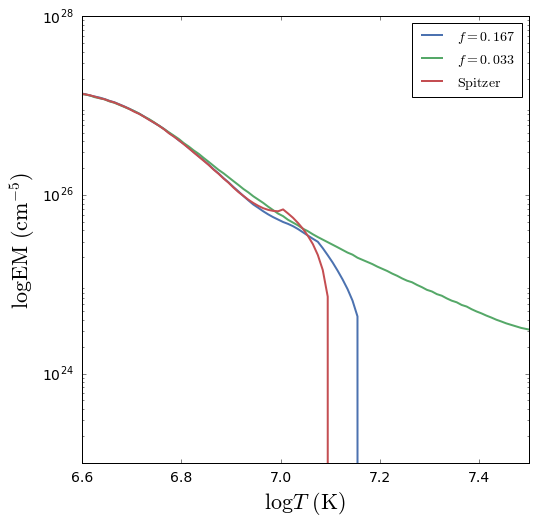

In [38]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
#plotting
for i in range(len(flux_lim_results)):
    #EBTEL
    binner = emb.EM_Binner(flux_lim_results[i]['t'],flux_lim_results[i]['T'],flux_lim_results[i]['n'],
                           2*config_dict['loop_length']*1e+8)
    binner.build_em_dist()
    hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
    if flux_lim[i][1]=='classical':
        plab = r'$\mathrm{Spitzer}$'
    else:
        plab = r'$f=%.3f$'%(flux_lim[i][0])
    ax.plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('deep')[i],
               linestyle='solid',label=plab)
    
#aesthetics
#scale
ax.set_yscale('log')
#limits
ax.set_ylim([1e+23,1e+28])
ax.set_xlim([6.6,7.5])
#ticks
#x
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
#y
ax.yaxis.set_major_locator(ticker.LogLocator(numticks=5))
#labels
ax.set_xlabel(r'$\log{T}$ $\mathrm{(K)}$')
ax.set_ylabel(r'$\log\mathrm{EM}$ $\mathrm{(cm}^{-5}\mathrm{)}$')
#legend
ax.legend(loc='best')
#save
plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_1/figures/f2.eps',format='eps',dpi=1000)
plt.show()

## Figure 3
Temperature, density, and $\mathrm{EM}$ for electron and ion heating. Three panels, same as Fig. 1. Probably will not show all pulse durations.

### Panel 1
Temperature as a function of $t$ for electron and ion heating.

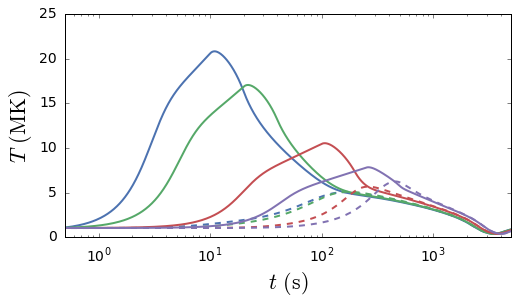

In [39]:
fig = plt.figure(figsize=(8,4))
ax = fig.gca()
#plotting
for i in range(len(tau_h_results)):
    #electron heating
    ax.plot(tau_h_results[i]['te'],tau_h_results[i]['Tee']/1e+6,color=sns.color_palette('deep')[i],
               linestyle='solid',label=r'$\tau=%d$ $\mathrm{s}$'%tau_h[i])
    ax.plot(tau_h_results[i]['te'],tau_h_results[i]['Tei']/1e+6,color=sns.color_palette('deep')[i],
               linestyle='dashed')
#scale
ax.set_xscale('log')
#limits
ax.set_xlim([0,5000])
#tick labels
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
#axes labels
ax.set_xlabel(r'$t$ $\mathrm{(s)}$')
ax.set_ylabel(r'$T$ $\mathrm{(MK)}$')
#legend
#ax.legend()
plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_1/figures/f3a.eps',format='eps',dpi=1000)
plt.show()

### Panel 2
Density as a function of $t$ for electron and ion heating.

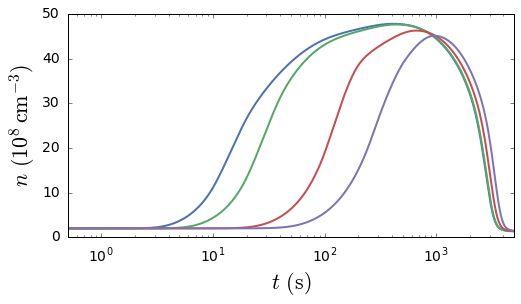

In [40]:
fig = plt.figure(figsize=(8,4))
ax = fig.gca()
#plotting
for i in range(len(tau_h_results)):
    #electron heating
    ax.plot(tau_h_results[i]['te'],tau_h_results[i]['ne']/1e+8,color=sns.color_palette('deep')[i],
               linestyle='solid',label=r'$\tau=%d$ $\mathrm{s}$'%tau_h[i])
#scale
ax.set_xscale('log')
#limits
ax.set_xlim([0,5000])
#tick labels
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
#axes labels
ax.set_xlabel(r'$t$ $\mathrm{(s)}$')
ax.set_ylabel(r'$n$ $(10^8\,\mathrm{cm}^{-3})$')
#legend
#ax.legend()
plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_1/figures/f3b.eps',format='eps',dpi=1000)
plt.show()

### Panel 3
$\mathrm{EM}(T)$ for electron and ion heating

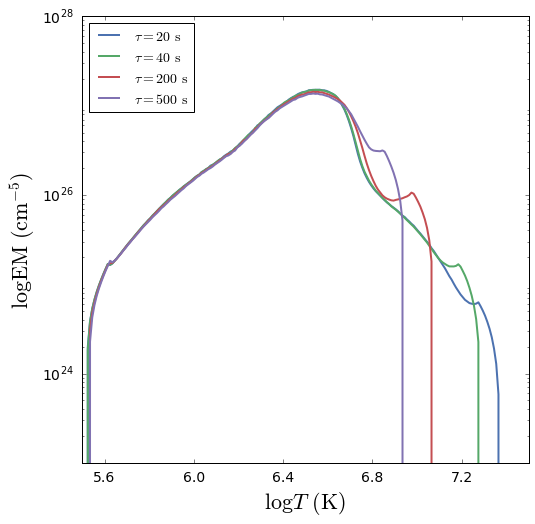

In [41]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
#plotting
for i in range(len(tau_h_results)):
    #EBTEL
    binner = emb.EM_Binner(tau_h_results[i]['te'],tau_h_results[i]['Tee'],tau_h_results[i]['ne'],
                           2*config_dict['loop_length']*1e+8)
    binner.build_em_dist()
    hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
    ax.plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('deep')[i],
               linestyle='solid',label=r'$\tau=%d$ $\mathrm{s}$'%tau_h[i])
    
#aesthetics
#scale
ax.set_yscale('log')
#limits
ax.set_ylim([1e+23,1e+28])
ax.set_xlim([5.5,7.5])
#ticks
#x
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
#y
ax.yaxis.set_major_locator(ticker.LogLocator(numticks=5))
#labels
ax.set_xlabel(r'$\log{T}$ $\mathrm{(K)}$')
ax.set_ylabel(r'$\log\mathrm{EM}$ $\mathrm{(cm}^{-5}\mathrm{)}$')
#legend
ax.legend(loc=2)
#save
plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_1/figures/f3c.eps',format='eps',dpi=1000)
plt.show()

### $\mathrm{EM}$ Slope Diagnostics

In [24]:
btest = emb.EM_Binner(tau_h_results[2]['te'],tau_h_results[2]['Tee'],tau_h_results[2]['ne'],
                           2*config_dict['loop_length']*1e+8)
btest.build_em_dist()
hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
lT_test = (bin_edges[:-1]+bin_edges[1:])/2
em_test = hist/10

In [25]:
iTest = np.where((lT_test > 6.6) & (lT_test < 6.8))
Tsteep  = lT_test[iTest[0]]
EMsteep = em_test[iTest[0]]

(6, 7)

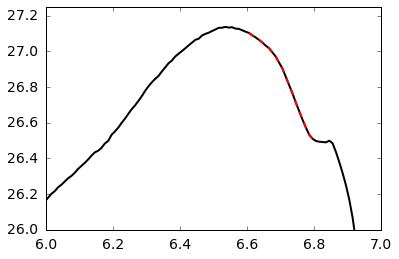

In [26]:
plt.plot(lT_test,np.log10(em_test),'k')
plt.plot(Tsteep,np.log10(EMsteep),'--r')
plt.ylim([26,27.25])
plt.xlim([6,7])

In [27]:
iEb = np.where((tau_h_results[2]['Tee'] > 10**6.6) & (tau_h_results[2]['Tee'] < 10**6.8))

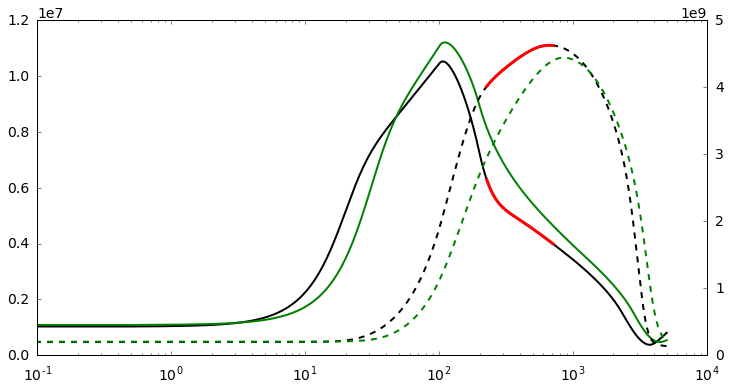

In [28]:
fig = plt.figure(figsize=(12,6))
ax = fig.gca()
ax2 = ax.twinx()
ax.plot(tau_h_results[2]['te'],tau_h_results[2]['Tee'],'k')
ax.plot(tau_h_results[2]['t'],tau_h_results[2]['T'],'g')
ax.plot(tau_h_results[2]['te'][iEb[0]][tau_h_results[2]['te'][iEb[0]]>100],
        tau_h_results[2]['Tee'][iEb[0]][tau_h_results[2]['te'][iEb[0]]>100],'r',linewidth=3)
ax2.plot(tau_h_results[2]['te'],tau_h_results[2]['ne'],'--k')
ax2.plot(tau_h_results[2]['t'],tau_h_results[2]['n'],'--g')
ax2.plot(tau_h_results[2]['te'][iEb[0]][tau_h_results[2]['te'][iEb[0]]>100],
         tau_h_results[2]['ne'][iEb[0]][tau_h_results[2]['te'][iEb[0]]>100],'r',linewidth=3)
ax.set_xscale('log')
ax2.set_xscale('log')

## Figure 3+$\varepsilon^{'''}$

Added an extra figure here in the middle to show the $p(T)$ and $n(T)$ state space for EBTEL two-fluid runs for $\tau=200$ s.

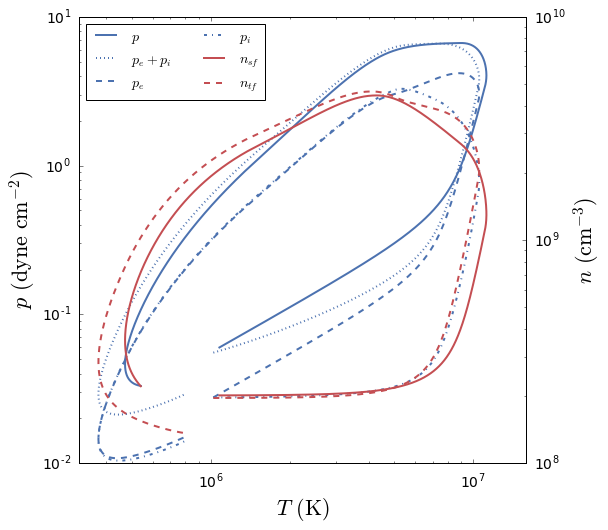

In [42]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
axn = ax.twinx()
#total pressure--single fluid
linep = ax.plot(tau_h_results[2]['T'],2.*ac.k_B.cgs.value*tau_h_results[2]['n']*tau_h_results[2]['T'],
       color=sns.color_palette('deep')[0],linestyle='solid',label=r'$p$')
#total pressure--two fluid
linep_tot = ax.plot(tau_h_results[2]['Tee'],
        ac.k_B.cgs.value*tau_h_results[2]['ne']*tau_h_results[2]['Tee']+ac.k_B.cgs.value*tau_h_results[2]['ne']*tau_h_results[2]['Tei'],
       color=sns.color_palette('deep')[0],linestyle='dotted',label=r'$p_e+p_i$')
#electron pressure
linepe = ax.plot(tau_h_results[2]['Tee'],
        ac.k_B.cgs.value*tau_h_results[2]['ne']*tau_h_results[2]['Tee'],
       color=sns.color_palette('deep')[0],linestyle='dashed',label=r'$p_e$')
#ion pressure
linepi = ax.plot(tau_h_results[2]['Tee'],
        ac.k_B.cgs.value*tau_h_results[2]['ne']*tau_h_results[2]['Tei'],
       color=sns.color_palette('deep')[0],linestyle='-.',label=r'$p_i$')
#density--single-fluid
linensf = axn.plot(tau_h_results[2]['T'],tau_h_results[2]['n'],
       color=sns.color_palette('deep')[2],linestyle='solid',label=r'$n_{sf}$')
#density--two-fluid
linentf = axn.plot(tau_h_results[2]['Tee'],tau_h_results[2]['ne'],
       color=sns.color_palette('deep')[2],linestyle='dashed',label=r'$n_{tf}$')
#axes properties
#limits
ax.set_xlim([10**5.5,10**7.2])
axn.set_xlim([10**5.5,10**7.2])
#scale
ax.set_yscale('log')
axn.set_yscale('log')
ax.set_xscale('log')
axn.set_xscale('log')
#labels
ax.set_xlabel(r'$T$ $\mathrm{(K)}$')
ax.set_ylabel(r'$p$ $(\mathrm{dyne}$ $\mathrm{cm}^{-2})$')
axn.set_ylabel(r'$n$ $(\mathrm{cm}^{-3})$')
#legend
lines = linep + linep_tot + linepe + linepi + linensf + linentf
labels = []
[labels.append(l.get_label()) for l in lines]
ax.legend(lines,labels,loc=2,ncol=2)
#show
plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_1/figures/f4.eps',format='eps',dpi=1000)
plt.show()

## Figure 4
Three panel figure for ion heating: $n,T,\mathrm{EM}(T)$.

### Panel 1

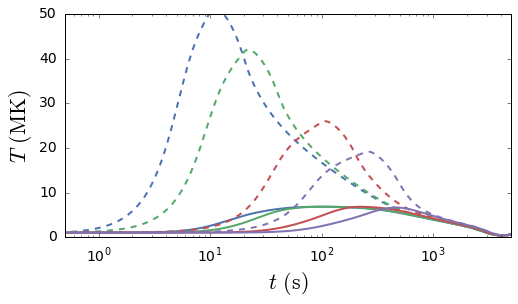

In [43]:
fig = plt.figure(figsize=(8,4))
ax = fig.gca()
#plotting
for i in range(len(tau_h_results)):
    #ion heating
    ax.plot(tau_h_results[i]['ti'],tau_h_results[i]['Tie']/1e+6,color=sns.color_palette('deep')[i],
               linestyle='solid',label=r'$\tau=%d$ $\mathrm{s}$'%tau_h[i])
    ax.plot(tau_h_results[i]['ti'],tau_h_results[i]['Tii']/1e+6,color=sns.color_palette('deep')[i],
               linestyle='dashed')
#scale
ax.set_xscale('log')
#limits
ax.set_xlim([0,5000])
ax.set_ylim([0,50])
#tick labels
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
#axes labels
ax.set_xlabel(r'$t$ $\mathrm{(s)}$')
ax.set_ylabel(r'$T$ $\mathrm{(MK)}$')
#legend
#ax.legend()
plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_1/figures/f5a.eps',format='eps',dpi=1000)
plt.show()

### Panel 2

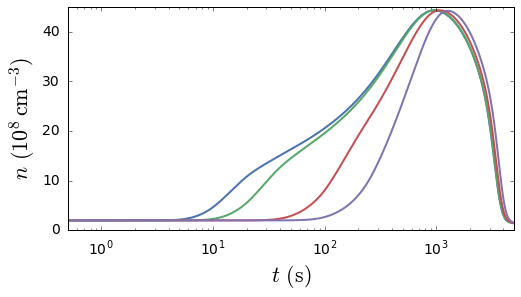

In [44]:
fig = plt.figure(figsize=(8,4))
ax = fig.gca()
#plotting
for i in range(len(tau_h_results)):
    #electron heating
    ax.plot(tau_h_results[i]['ti'],tau_h_results[i]['ni']/1e+8,color=sns.color_palette('deep')[i],
               linestyle='solid',label=r'$\tau=%d$ $\mathrm{s}$'%tau_h[i])
#scale
ax.set_xscale('log')
#limits
ax.set_xlim([0,5000])
#tick labels
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
#axes labels
ax.set_xlabel(r'$t$ $\mathrm{(s)}$')
ax.set_ylabel(r'$n$ $(10^8\,\mathrm{cm}^{-3})$')
#legend
#ax.legend()
plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_1/figures/f5b.eps',format='eps',dpi=1000)
plt.show()

### Panel 3

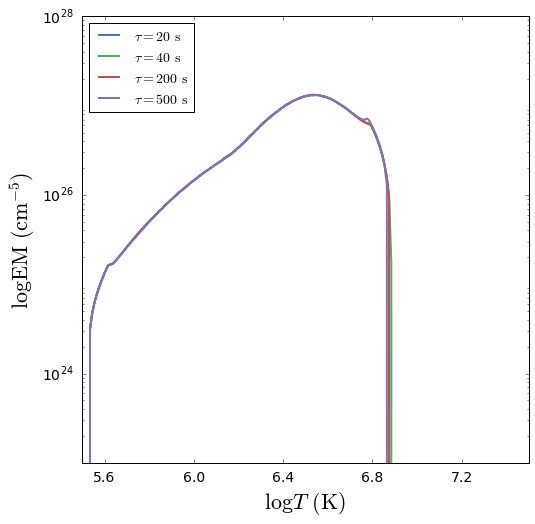

In [45]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
#plotting
for i in range(len(tau_h_results)):
    #EBTEL
    binner = emb.EM_Binner(tau_h_results[i]['ti'],tau_h_results[i]['Tie'],tau_h_results[i]['ni'],
                           2*config_dict['loop_length']*1e+8)
    binner.build_em_dist()
    hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
    ax.plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('deep')[i],
               linestyle='solid',label=r'$\tau=%d$ $\mathrm{s}$'%tau_h[i])
    
#aesthetics
#scale
ax.set_yscale('log')
#limits
ax.set_ylim([1e+23,1e+28])
ax.set_xlim([5.5,7.5])
#ticks
#x
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
#y
ax.yaxis.set_major_locator(ticker.LogLocator(numticks=5))
#labels
ax.set_xlabel(r'$\log{T}$ $\mathrm{(K)}$')
ax.set_ylabel(r'$\log\mathrm{EM}$ $\mathrm{(cm}^{-5}\mathrm{)}$')
#legend
ax.legend(loc=2)
#save
plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_1/figures/f5c.eps',format='eps',dpi=1000)
plt.show()

## Figure 5

Emission measure distribution comparing electron, ion, and single cases for both long (500 s) and short (20 s) pulses.

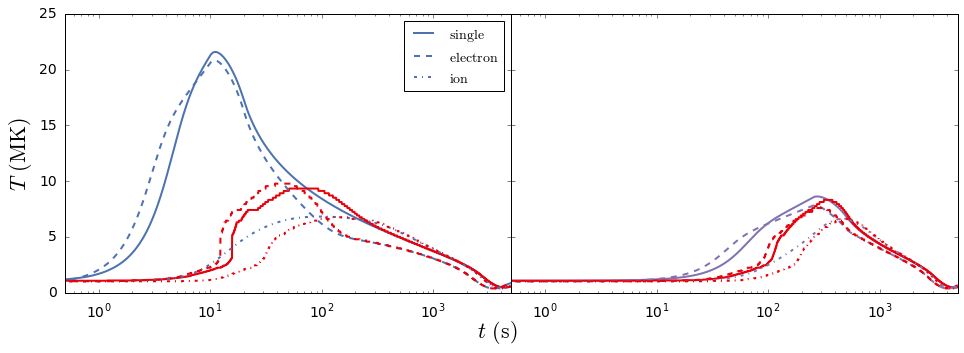

In [46]:
fig,ax = plt.subplots(1,2,figsize=(16,5),sharey=True)
plt.subplots_adjust(hspace=0.0,wspace=0.0)
#plotting
#short
ax[0].plot(f6a_single[:,0],f6a_single[:,1]/1e+6,color=sns.color_palette('deep')[0],linestyle='solid',
           label=r'$\mathrm{single}$')
ax[0].plot(f6a_single[:,0],f6a_single[:,2]/1e+6,color=sns.color_palette('bright')[2],linestyle='solid')
ax[0].plot(f6a_electron[:,0],f6a_electron[:,1]/1e+6,color=sns.color_palette('deep')[0],linestyle='dashed',
           label=r'$\mathrm{electron}$')
ax[0].plot(f6a_electron[:,0],f6a_electron[:,2]/1e+6,color=sns.color_palette('bright')[2],linestyle='dashed')
ax[0].plot(f6a_ion[:,0],f6a_ion[:,1]/1e+6,color=sns.color_palette('deep')[0],linestyle='-.',
           label=r'$\mathrm{ion}$')
ax[0].plot(f6a_ion[:,0],f6a_ion[:,2]/1e+6,color=sns.color_palette('bright')[2],linestyle='-.')
#long
ax[1].plot(f6b_single[:,0],f6b_single[:,1]/1e+6,color=sns.color_palette('deep')[3],linestyle='solid',
           label=r'$\mathrm{single}$')
ax[1].plot(f6b_single[:,0],f6b_single[:,2]/1e+6,color=sns.color_palette('bright')[2],linestyle='solid')
ax[1].plot(f6b_electron[:,0],f6b_electron[:,1]/1e+6,color=sns.color_palette('deep')[3],linestyle='dashed',
           label=r'$\mathrm{electron}$')
ax[1].plot(f6b_electron[:,0],f6b_electron[:,2]/1e+6,color=sns.color_palette('bright')[2],linestyle='dashed')
ax[1].plot(f6b_ion[:,0],f6b_ion[:,1]/1e+6,color=sns.color_palette('deep')[3],linestyle='-.',
           label=r'$\mathrm{ion}$')
ax[1].plot(f6b_ion[:,0],f6b_ion[:,2]/1e+6,color=sns.color_palette('bright')[2],linestyle='-.')
#scale
ax[0].set_xscale('log')
ax[1].set_xscale('log')
#limits
ax[0].set_xlim([0,5000])
ax[1].set_xlim([0,5000])
ax[0].set_ylim([0,25])
ax[1].set_ylim([0,25])
#tick labels
ax[0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6,prune='lower'))
ax[1].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
#axes labels
ax[0].set_ylabel(r'$T$ $\mathrm{(MK)}$')
fig.text(0.5, 0.015, r'$t$ $\mathrm{(s)}$', ha='center', va='center',fontsize=22)
#legend
ax[0].legend(loc='best')
plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_1/figures/f6.eps',format='eps',dpi=1000)

## Figure 6

Emission measure distribution comparision between $T$ and $T_{eff}$ for some of the cases above. With this figure, Figure 5 becomes unnecessary.

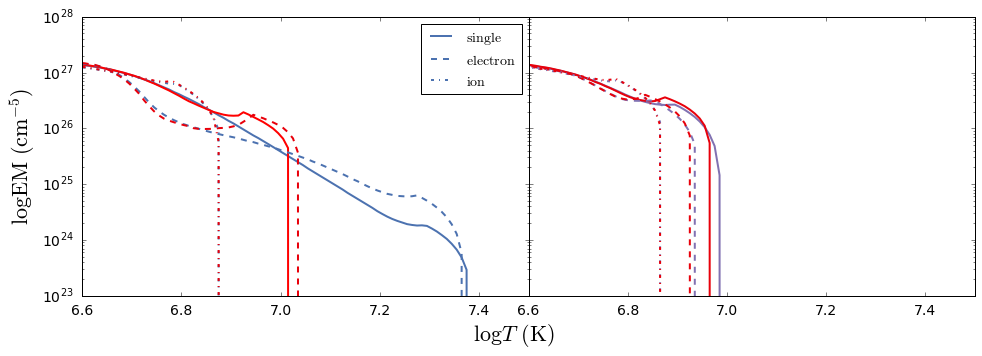

In [47]:
fig,ax = plt.subplots(1,2,figsize=(16,5),sharey=True)
plt.subplots_adjust(wspace=0.0,hspace=0.0)
#short
#single
binner = emb.EM_Binner(f6a_single[:,0],f6a_single[:,1],f6a_single[:,3],
                           2*config_dict['loop_length']*1e+8)
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
ax[0].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('deep')[0],linestyle='solid',
            label=r'$\mathrm{single}$')
binner = emb.EM_Binner(f6a_single[:,0],f6a_single[:,2],f6a_single[:,3],
                           2*config_dict['loop_length']*1e+8)
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
ax[0].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color='r',linestyle='solid')
#electron
binner = emb.EM_Binner(f6a_electron[:,0],f6a_electron[:,1],f6a_electron[:,3],
                           2*config_dict['loop_length']*1e+8)
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
ax[0].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('deep')[0],linestyle='dashed',
            label=r'$\mathrm{electron}$')
binner = emb.EM_Binner(f6a_electron[:,0],f6a_electron[:,2],f6a_electron[:,3],
                           2*config_dict['loop_length']*1e+8)
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
ax[0].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('bright')[2],linestyle='dashed')
#ion
binner = emb.EM_Binner(f6a_ion[:,0],f6a_ion[:,1],f6a_ion[:,3],
                           2*config_dict['loop_length']*1e+8)
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
ax[0].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('deep')[0],linestyle='-.',
            label=r'$\mathrm{ion}$')
binner = emb.EM_Binner(f6a_ion[:,0],f6a_ion[:,2],f6a_ion[:,3],
                           2*config_dict['loop_length']*1e+8)
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
ax[0].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('bright')[2],linestyle='-.')
#long
binner = emb.EM_Binner(f6b_single[:,0],f6b_single[:,1],f6b_single[:,3],
                           2*config_dict['loop_length']*1e+8)
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
ax[1].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('deep')[3],linestyle='solid',
            label=r'$\mathrm{single}$')
binner = emb.EM_Binner(f6b_single[:,0],f6b_single[:,2],f6b_single[:,3],
                           2*config_dict['loop_length']*1e+8)
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
ax[1].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('bright')[2],linestyle='solid')
#electron
binner = emb.EM_Binner(f6b_electron[:,0],f6b_electron[:,1],f6b_electron[:,3],
                           2*config_dict['loop_length']*1e+8)
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
ax[1].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('deep')[3],linestyle='dashed',
            label=r'$\mathrm{electron}$')
binner = emb.EM_Binner(f6b_electron[:,0],f6b_electron[:,2],f6b_electron[:,3],
                           2*config_dict['loop_length']*1e+8)
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
ax[1].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('bright')[2],linestyle='dashed')
#ion
binner = emb.EM_Binner(f6b_ion[:,0],f6b_ion[:,1],f6b_ion[:,3],
                           2*config_dict['loop_length']*1e+8)
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
ax[1].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('deep')[3],linestyle='-.',
            label=r'$\mathrm{ion}$')
binner = emb.EM_Binner(f6b_ion[:,0],f6b_ion[:,2],f6b_ion[:,3],
                           2*config_dict['loop_length']*1e+8)
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat))
ax[1].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('bright')[2],linestyle='-.')
#scale
ax[0].set_yscale('log')
ax[1].set_yscale('log')
#limits
ax[0].set_xlim([6.6,7.5])
ax[0].set_ylim([1e+23,1e+28])
ax[1].set_xlim([6.6,7.5])
ax[1].set_ylim([1e+23,1e+28])
#labels
fig.text(0.5, 0.015, r'$\log{T}$ $\mathrm{(K)}$', ha='center', va='center',fontsize=22)
ax[0].set_ylabel(r'$\log\mathrm{EM}$ $\mathrm{(cm}^{-5}\mathrm{)}$')
#legend
ax[0].legend(loc='best')
#save
plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_1/figures/f7.eps',format='eps',dpi=1000)